## SIF (Smooth Inverse Frequency) Embeddings

SIF is a simple sentence embedding technique. The sentence embeddings are calculated based on the weighted average of word embeddings.

The utility and SIF calculation functions are refactored from https://github.com/PrincetonML/SIF.

In [1]:
import os
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine
from keras.preprocessing import text, sequence
from sklearn.decomposition import TruncatedSVD
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


Text cleaning functions:

In [2]:
def get_punctuation_list(exclude_puncts=None, include_puncts=None):
    """ Get a customized punctuation list """
    if not exclude_puncts:
        exclude_puncts = []
    if not include_puncts:
        include_puncts = []
    puncts = [p for p in string.punctuation if p not in exclude_puncts]
    puncts.extend([p for p in include_puncts])
    return list(set(puncts))

def separate_punctuation(x, puncts):
    """ Add spaces around punctuations """
    for s in puncts:
        x = x.replace(s, f' {s} ')
    return x

def strip_space(x):
    """ Remove extra space around words """
    return ' '.join([s.strip() for s in x.split()])

def clean_text(x):
    x = str(x).lower()
    x = x.replace('\n', '').replace('\t', '')
    x = separate_punctuation(x, puncts)
    x = strip_space(x)
    return x

Tokenization and format functions:

In [3]:
def process_text_to_sequence(X_train, X_test, **kwargs):
    """
    Process text data (array) to equal length sequences use keras
    :param X_train : np.array with shape (m, )
    :param X_test  : np.array with shape (n, )
    :param kwargs  : other parameters needed
    :return:
    """
    max_features = kwargs.get('max_features', 10000)
    max_len = kwargs.get('max_len', 50)

    tokenizer = text.Tokenizer(num_words=max_features, lower=True, split=' ',
                               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                               char_level=False)
    tokenizer.fit_on_texts(list(X_train) + list(X_test))

    # process text to sequence
    X_train_sequence = tokenizer.texts_to_sequences(X_train)
    X_test_sequence = tokenizer.texts_to_sequences(X_test)

    # truncate / padding
    X_train_sequence_pad = sequence.pad_sequences(X_train_sequence, maxlen=max_len)
    X_test_sequence_pad = sequence.pad_sequences(X_test_sequence, maxlen=max_len)

    return X_train_sequence, X_test_sequence, X_train_sequence_pad, X_test_sequence_pad, tokenizer

def load_pretrained_word_embeddings(embedding_path, tokenizer, **kwargs):
    """
    Load pretrained word embeddings
    :param embedding_path : str, example: './embeddings/glove.840B.300d/glove.840B.300d.txt'
    :param tokenizer      : keras tokenizer, return from process_text_to_sequence
    :param kwargs         : other parameters needed
    :return:
    """

    embedding_size = kwargs.get('embedding_size', 300)
    max_features = kwargs.get('max_features', 10000)
    
    # word_pretrained_index: key = word, value = index in pretrained embeddings
    word_pretrained_index = {}
    
    def _get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(
        _get_coefs(*o.strip().rsplit(' ')) for o in open(embedding_path))
    embeddings_vocab = list(embeddings_index.keys())
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index))
    embeddings_matrix = np.zeros((num_words, embedding_size))
    for word, i in word_index.items():
        i -= 1
        if i >= max_features:
            continue
        embeddings_vector = embeddings_index.get(word)
        # oov or not
        if embeddings_vector is not None:
            embeddings_matrix[i] = embeddings_vector
            word_pretrained_index[word] = embeddings_vocab.index(word)
        
        # make 0 as start
        word_index[word] -= 1
        
    return word_pretrained_index, word_index, embeddings_matrix

Utility functions (get term-frequency weights):

In [4]:
def get_word_weight(weight_filename, alpha=1e-3):
    """ Get word term-frequency from large corpus file """
    # when the parameter makes no sense, use unweighted
    if alpha <= 0: 
        alpha = 1.0
    
    words_weight = {}
    with open(weight_filename) as f:
        lines = f.readlines()
     
    # total term-frequency
    N = 0
    for word_tf in lines:
        word_tf = word_tf.strip()
        if len(word_tf) == 0:
            continue
        word_tf = word_tf.split()
        if len(word_tf) == 2:
            word = word_tf[0]
            tf = word_tf[1]
            words_weight[word] = float(tf)
            N += float(tf)
        else:
            print('{} not a valid (word, termfrequency) record'.format(i))
                
    # normalize weights by alpha and N
    for word, tf in words_weight.items():
        words_weight[word] = alpha / (alpha + tf / N)
        
    return words_weight

def lookup_pretrained_index(words_pretrained_index, word):
    word = word.lower()
    if len(word) > 1 and word[0] == '#':
        word = word.replace("#", "")
        
    if word in words_pretrained_index:
        return words_pretrained_index[word]
    elif 'UUUNKKK' in words_pretrained_index:
        return words_pretrained_index['UUUNKKK']
    else:
        return len(words_pretrained_index) - 1

def get_pretrained_index_weight(word_pretrained_index, words_weight):
    """ Get the map from word index in pretrained embeddings and weights """
    index_weights = {}
    for word, idx in word_pretrained_index.items():
        if word in words_weight:
            index_weights[idx] = words_weight[word]
        else:
            index_weights[idx] = 1.0
    return index_weights

def get_sentence_pretrained_index(sentences, words_pretrained_index):
    """
    Given a list of sentences, output array of word indices 
    that can be fed into the algorithms.
    Since sentences have different length, 0 will be padded at 
    the end for sentence length less than max length
    
    :param sentences: 
    :param words_pretrained_index:
    :return: word_index_sentence, mask. 
             word_index_sentence[i, :] is the word indices in sentence i
             mask[i,:] is the mask for sentence i (0 means no word at the location)
    """
    def get_sequence(sentence, words_pretrained_index):
        return [lookup_pretrained_index(words_pretrained_index, word) for word in sentence.split()]

    sequence = [get_sequence(sentence, words_pretrained_index) for sentence in sentences]
    word_index_sentence, mask = pad_sequences(sequence)
    return word_index_sentence, mask

def pad_sequences(sequences):
    """ Padding 0 to sequences that shorter than max length """
    lengths = [len(s) for s in sequences]
    n_samples = len(sequences)
    maxlen = np.max(lengths)
    
    x = np.zeros((n_samples, maxlen)).astype('int32')
    x_mask = np.zeros((n_samples, maxlen)).astype('float32')
    for idx, sentence in enumerate(sequences):
        x[idx, :lengths[idx]] = sentence
        x_mask[idx, :lengths[idx]] = 1.
    x_mask = np.asarray(x_mask, dtype='float32')
    return x, x_mask

def get_word_weights_sequence(sequences, mask, index_weights):
    """ Get word weights for sentences """
    weight = np.zeros(sequences.shape).astype('float32')
    
    for i in range(sequences.shape[0]):
        for j in range(sequences.shape[1]):
            if mask[i, j] > 0 and sequences[i, j] >= 0:
                weight[i, j] = index_weights[sequences[i, j]]
    
    weight = np.asarray(weight, dtype='float32')
    return weight

SIF embedding calculation functions:

In [5]:
def get_weighted_average(embedding_matrix, word_index_sentence, weights):
    """ Compute the weighted average word embeddings """
    n_samples = word_index_sentence.shape[0]
    embedding_matrix_avg = np.zeros((n_samples, embedding_matrix.shape[1]))
    for i in range(n_samples):
        total_weights = np.count_nonzero(weights[i, :])
        embedding_matrix_avg[i,:] = weights[i, :].dot(embedding_matrix[word_index_sentence[i, :], :]) / total_weights
    return embedding_matrix_avg

def compute_pc(X, n_components=1, **kwargs):
    """ Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN! """
    svd = TruncatedSVD(n_components=n_components, **kwargs)
    svd.fit(X)
    return svd.components_

def remove_pc(X, n_components_rm=1, **kwargs):
    """ Remove the projection on the principal components """
    n_components = kwargs.get('n_components', 1)
    pc = compute_pc(X, n_components, random_state=2020)
    if n_components_rm == 1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

def sif_embeddings(embeddings_matrix, word_index_sentence, weights):
    """ Get SIF embeddings """
    embeddings_matrix_avg = get_weighted_average(embeddings_matrix, word_index_sentence, weights)
    embeddings_matrix_avg_rm_pc = remove_pc(embeddings_matrix_avg)
    return embeddings_matrix_avg_rm_pc

In [6]:
data_path = '../input/quora-question-pairs/'
word_embedding_file = '../input/glove840b300dtxt/glove.840B.300d.txt'
word_weight_file = '../input/enwiki-vocab-min200//enwiki_vocab_min200.txt'
weight_para = 1e-3

train = pd.read_csv(os.path.join(data_path, 'train.csv.zip'))
train[['question1', 'question2']].fillna('', inplace=True)

puncts = get_punctuation_list(exclude_puncts=['$', '-', '_'])
train['question1'] = train['question1'].apply(clean_text)
train['question2'] = train['question2'].apply(clean_text)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor ( koh-i-noor ) d...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely ? how can i solv...,find the remainder when [ math ] 23 ^ { 24 } [...,0
4,4,9,10,"which one dissolve in water quikly sugar , sal...",which fish would survive in salt water ?,0


In [7]:
train_size = train.shape[0]
sentences = train['question1'].tolist() + train['question2'].tolist()
X_train = np.array(sentences)
X_test = np.array(sentences[:2])
print(X_train.shape, X_test.shape)

(808580,) (2,)


In [8]:
_, _, _, _, tokenizer = process_text_to_sequence(X_train, X_test, max_features=1000000, max_len=100)
word_pretrained_index, word_index, embeddings_matrix = load_pretrained_word_embeddings(word_embedding_file,
                                                                   tokenizer,
                                                                   max_features=1000000,
                                                                   max_len=100)

In [9]:
word_weight = get_word_weight(word_weight_file, weight_para)
index_weights = get_pretrained_index_weight(word_index, word_weight)
word_index_sentence, mask = get_sentence_pretrained_index(sentences, word_index)
weights = get_word_weights_sequence(word_index_sentence, mask, index_weights)

In [10]:
sentence_embeddings = get_weighted_average(embeddings_matrix, word_index_sentence, weights)
print(sentence_embeddings.shape)

(808580, 300)


In [11]:
question1_embeddings = sentence_embeddings[:train_size]
question2_embeddings = sentence_embeddings[train_size:]
print(question1_embeddings.shape, question2_embeddings.shape)

(404290, 300) (404290, 300)


In [12]:
cosine_similarities = []
for i in range(train_size):
    sentence_1 = question1_embeddings[i]
    sentence_2 = question2_embeddings[i]
    cosine_similarities.append(1 - cosine(sentence_1, sentence_2))
    
train['cosine_similarity'] = cosine_similarities
train.to_csv('train_questions_sif_cosine_similarity.csv', index=False)

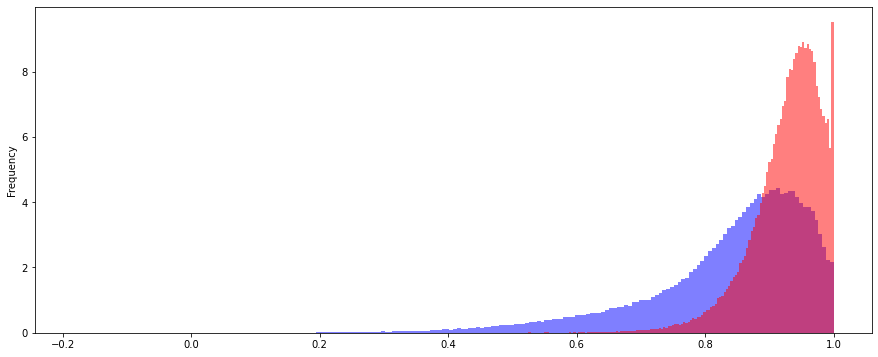

In [13]:
plot_params = dict(kind='hist', bins=200, alpha=0.5, figsize=(15, 6), density=True)
ax = train.loc[train['is_duplicate'] == 0, 'cosine_similarity'].plot(color='blue', **plot_params)
_ = train.loc[train['is_duplicate'] == 1, 'cosine_similarity'].plot(color='red', ax=ax, **plot_params)